# Multi-asset Portfolio Analytics
## Optimisation, Risk & Monte Carlo Simulation

---

## Overview
End‑to‑end Python framework for **multi‑asset portfolio construction**, **efficient frontier optimisation**, and **multi‑method risk analysis** (historical, parametric, Monte Carlo VaR & CVaR), with **forward price simulation**, **PnL distribution**, and **drawdown analysis**.

---

## Features

- **Portfolio Optimisation**
  - Mean‑variance optimisation (Max‑Sharpe) with constraints (long‑only or short‑allowed)
  - Efficient Frontier plotting

- **Risk Analysis**
  - Historical VaR & CVaR
  - Parametric VaR & CVaR (Normal, time scaling)
  - Monte Carlo VaR & CVaR

- **Forward Simulation**
  - Monte Carlo price projection
  - PnL distribution with probability of loss
  - Drawdown trajectories and max drawdown stats

- **Visualisations**
  - Efficient Frontier with clear labels
  - Loss distribution CDFs
  - Monte Carlo fan charts
  - Average drawdown curves

- **Export**
  - Excel export of PnL and drawdown results for reporting



---

### FinancialData & ChosenTickers Classes

These classes are designed to **prepare the financial data** that will be used to build the desired portfolio.

- **`FinancialData`**: collects and preprocesses raw financial data.  
- **`ChosenTickers`**: selects the assets that will make up the portfolio.

---

### Portfolio Class

`Portfolio` is a **subclass** of `ChosenTickers`.  
It uses the prepared data to **compute the optimal asset weights** via the **Efficient Frontier**, and then builds the portfolio.

#### Key Point

**Choosing weights with `efficient_frontier_with_alpha`**  
Use this method to decide how you want to weight your portfolio:
   - `alpha = 1.0` → **Max Sharpe** (highest risk‑adjusted return)
   - `alpha = 0.0` → **Min Volatility** (most stable portfolio)
   - `0 < alpha < 1` → **Compromise** between Sharpe and low volatility

   Example:
   ```python
   portfolio.efficient_frontier_with_alpha(alpha=0.65)

In [8]:
# Use libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

from scipy.stats import norm, shapiro
from scipy.optimize import minimize

# Helpers
PERIODS_PER_YEAR = {'1d': 252, '1wk': 52, '1mo': 12}

def _periods_per_year(interval: str) -> int:
    return PERIODS_PER_YEAR.get(interval, 252)

def _ensure_alpha(alpha_or_pct) -> float:
    a = float(alpha_or_pct)
    return a / 100.0 if a > 1.0 else a

class FinancialData:
    # Class to enable (1) data downloading via Yahoo Finance AND (2) clean the data

    def __init__(self, ticker: str | list[str], end_date, duration: int, chosen_interval: str):
        self.ticker = ticker
        self.end_date = pd.Timestamp(end_date)
        self.duration = int(duration)
        self.chosen_interval = chosen_interval
        self._df = None  # cache

    # Function to download data
    def download(self):
        if self._df is not None:
            return self._df.copy()
        delta = dt.timedelta(self.duration)
        start_date = self.end_date - delta
        df = yf.download(
            self.ticker,
            start=start_date,
            end=self.end_date,
            interval=self.chosen_interval,
            auto_adjust=True,
            progress=False
        )
        self._df = self.clean_data(df)
        return self._df.copy()

    # Function to clean the data
    @staticmethod
    def clean_data(df):
        if isinstance(df.columns, pd.MultiIndex):
            if 'Close' in df.columns.get_level_values(0):
                df = df['Close']
            df.columns = [f"{c}_Close" for c in df.columns]
            return df.sort_index().ffill().dropna(how='any')
        cols = [c for c in ['Open', 'High', 'Low', 'Close', 'Volume'] if c in df.columns]
        return df[cols].sort_index().ffill().dropna(how='any')


class ChosenTickers:
    # Class to enable user to choose several Tickers and type of returns to work with

    def __init__(self, tickers_list: list[str], end_date, duration: int, chosen_interval: str):
        self.tickers_list = tickers_list
        self.end_date = pd.Timestamp(end_date)
        self.duration = int(duration)
        self.chosen_interval = chosen_interval
        self.ppy = _periods_per_year(chosen_interval)
        self._prices = None
        self._simp_returns = None
        self._log_returns = None

    '''
    Choice between dataframe of Adjust Close Price, Simple Returns or Log Returns
    '''

    def download_all_close(self):
        if self._prices is not None:
            return self._prices.copy()
        fd = FinancialData(self.tickers_list, self.end_date, self.duration, self.chosen_interval)
        df = fd.download()
        if {'Open', 'High', 'Low', 'Close', 'Volume'}.issubset(set(df.columns)):
            name = f'{self.tickers_list[0]}_Close'
            df = df[['Close']].rename(columns={'Close': name})
        self._prices = df.sort_index().dropna(how='any')
        return self._prices.copy()

    def download_all_simp_returns(self):
        if self._simp_returns is not None:
            return self._simp_returns.copy()
        prices = self.download_all_close()
        simp = prices.pct_change().dropna()
        simp.columns = [c.replace('_Close', '_simp_returns') for c in simp.columns]
        self._simp_returns = simp
        return self._simp_returns.copy()

    def download_all_log_returns(self):
        if self._log_returns is not None:
            return self._log_returns.copy()
        prices = self.download_all_close()
        log = np.log(prices / prices.shift(1)).dropna()
        log.columns = [c.replace('_Close', '_log_returns') for c in log.columns]
        self._log_returns = log
        return self._log_returns.copy()


class Portfolio(ChosenTickers):
    '''
    Portfolio class for creating a portfolio object,running optimisation, computing portfolio value series,
    and plotting the efficient frontier
    '''

    def __init__(self, tickers_list: list[str], end_date, duration: int, chosen_interval: str,
                 capital: float, allow_short: bool = False):
        super().__init__(tickers_list, end_date, duration, chosen_interval)
        self.capital = float(capital)
        self.allow_short = allow_short
        self.weights = None
        self.value_series = None

    # Method to compute the portfolio value with the given weights
    def optimized_pf(self):
        '''
        Compute the portfolio value series using the efficient frontier
        '''
        if self.weights is None:
            self.efficient_frontier_with_alpha(alpha=0.5)

        prices_df = self.download_all_close()
        ordered_cols = [f'{t}_Close' for t in self.tickers_list]
        prices_df = prices_df[ordered_cols]

        # Match weights to tickers_list order
        w = np.array([self.weights[f'{t}_log_returns'] if f'{t}_log_returns' in self.weights else self.weights[t]
                      for t in self.tickers_list])

        # Normalise prices and compute total portfolio value
        norm_px = prices_df / prices_df.iloc[0]
        total_value = self.capital * (norm_px.to_numpy() @ w)

        weighted_df = prices_df.copy()
        weighted_df['Total_Portfolio_Value'] = total_value
        self.value_series = weighted_df
        return weighted_df

    # Method to compute and plot the Efficient Frontier
    def efficient_frontier_with_alpha(self, num_points: int = 50, use_log_returns=True,
                                   risk_free_rate_annual=0.0, alpha: float = 1.0):
        '''
        Compute the efficient frontier and select a portfolio based on alpha:
        alpha = 1.0 -> Max Sharpe
        alpha = 0.0 -> Min Volatility
        0 < alpha < 1 -> Compromise between Sharpe and low volatility
        '''
        # 1. Get returns
        R = self.download_all_log_returns() if use_log_returns else self.download_all_simp_returns()
        mu_per = R.mean().to_numpy()
        cov_per = R.cov().to_numpy()
        ppy = self.ppy
        mu_ann_assets = mu_per * ppy

        # 2. Target returns for the frontier
        lo, hi = np.quantile(mu_ann_assets, [0.1, 0.9])
        targets_ann = np.linspace(lo, hi, num_points)
        n = len(mu_per)
        bounds = None if self.allow_short else tuple((0.0, 1.0) for _ in range(n))

        risk_ann, ret_ann, sharpe_ratios, weights_list = [], [], [], []
    
        # 3. Loop over target returns
        for m_target_ann in targets_ann:
            m_target_per = m_target_ann / ppy
            cons = (
                {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
                {'type': 'eq', 'fun': lambda w, mu=mu_per: w @ mu - m_target_per}
            )

            def port_var(w):
                return w @ cov_per @ w
    
            res = minimize(port_var, x0=np.full(n, 1/n), method='SLSQP', bounds=bounds, constraints=cons)
            if res.success:
                w = res.x
                sigma_ann = np.sqrt(max(w @ cov_per @ w, 1e-18)) * np.sqrt(ppy)
                ret_a = w @ mu_per * ppy
                sharpe = (ret_a - risk_free_rate_annual) / sigma_ann if sigma_ann > 0 else -np.inf

                risk_ann.append(sigma_ann)
                ret_ann.append(ret_a)
                sharpe_ratios.append(sharpe)
                weights_list.append(w)

        # 4. Normalisation 
        max_sharpe_val = max(sharpe_ratios)
        max_vol = max(risk_ann)
        scores = [
            alpha * (sh / max_sharpe_val) - (1 - alpha) * (vol / max_vol)
            for sh, vol in zip(sharpe_ratios, risk_ann)
        ]

        # 5. Asset choice regarding of the alpha
        best_idx = int(np.argmax(scores))
        self.weights = dict(zip(R.columns, weights_list[best_idx]))

        # 6. Plot
        plt.figure(figsize=(7, 5))
        plt.plot(risk_ann, ret_ann, color='darkgreen', lw=2, label='Efficient Frontier')
        plt.scatter(risk_ann[best_idx], ret_ann[best_idx], color='red', s=80,
                    label=f'Alpha={alpha:.2f} Portfolio')
        plt.xlabel('Annualized Volatility')
        plt.ylabel('Annualized Return')
        plt.title('Efficient Frontier with Alpha-Selected Portfolio')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

        return self.weights

---
### RiskAnalyses Class

The `RiskAnalyses` class is designed to **compute and visualize portfolio risk metrics**, focusing on **Value at Risk (VaR)** and **Conditional Value at Risk (CVaR)** using three different approaches:

- **Historical VaR/CVaR**  
  Based on the actual distribution of past returns.

- **Parametric VaR/CVaR**  
  Assumes returns follow a specific distribution (e.g., normal) and uses statistical parameters (mean, standard deviation).

- **Monte Carlo VaR/CVaR**  
  Simulates a large number of hypothetical return scenarios to estimate risk metrics.

#### Key Features
- Calculates **VaR**: the maximum expected loss over a given time horizon at a specified confidence level.
- Calculates **CVaR**: the expected loss **beyond** the VaR threshold (tail risk).
- Supports **multiple methodologies** for flexibility and comparison.
- Produces **visualizations** to help interpret and communicate risk profiles.

**In summary**:  
The `RiskAnalyses` class allows you to **quantify and visualize downside risk** from different perspectives, making it easier to understand potential losses under normal and extreme market conditions.


In [9]:
class RiskAnalysis ():

    # Class to perform the different VaR and CVaR computing

    '''
    Always compute VaR and CVaR and display a visualization
    Convention: losses are shown as negative values on plots (so left side = worse losses)
    Internally, VaR/CVaR are computed as loss magnitudes (positive), but we plot their negatives
    '''

    def __init__(self, df: pd.DataFrame):
        if 'Total_Portfolio_Value' not in df.columns:
            raise ValueError("DataFrame must contain 'Total_Portfolio_Value'")
        self.df = df.copy().sort_index()

    # Helper to compute simple returns and keep coherence across methods
    def _simple_returns (self) -> pd.Series :
        ret = self.df['Total_Portfolio_Value'].pct_change().dropna()
        return ret

    # Helper to compute simple returns and keep coherence across methods
    def _log_returns (self) -> pd.Series : 
        ret = np.log(self.df['Total_Portfolio_Value'] / self.df['Total_Portfolio_Value'].shift(1)).dropna()
        return ret

    def var_hist (self, confidence_level) :
        # Compute simple returns of pf
        alpha = _ensure_alpha(confidence_level)
        ret = self._simple_returns()

        # Historical VaR/CVaR computed on returns directly (left tail)
        var_val = float(np.quantile(ret, 1 - alpha))    # negative if loss
        cvar_val = float(ret[ret <= var_val].mean())    # negative

        # Sort the returns for plotting (CDF)
        returns = np.sort(ret.to_numpy())
        n = returns.size
        cdf = (np.arange(1, n+1)/n)

        # Plot the CDF of returns (losses on the left)
        plt.figure(figsize=(9,4))
        plt.plot(returns, cdf, marker='.', linestyle='-', color='green', linewidth=2, label ='CDF of returns')
        # Draw vertical lines at VaR and CVaR (both negative, on the left)
        plt.axvline(x=var_val, color='red', linestyle=':', linewidth=1, label=f'VaR {int(alpha*100)}% = {var_val:.4f}')
        plt.axvline(x=cvar_val, color='orange', linestyle=':', linewidth=1, label=f'CVaR {int(alpha*100)}% = {cvar_val:.4f}')
        plt.xlabel('Simple Returns (losses on the left)')
        plt.ylabel('CDF')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title('Historical VaR/CVaR (returns view)')
        plt.show()

        # Return magnitudes (positive) for metrics, and signed for reference if needed
        var_mag = abs(var_val)
        cvar_mag = abs(cvar_val)
        return var_mag, cvar_mag, var_val, cvar_val

    
    def var_param(self, confidence_level, days: int):
        alpha = _ensure_alpha(confidence_level)
    
        # Param on log returns to normalized
        ret = self._log_returns()
    
        # Shapiro-Wilk Normality check
        stat, p_value = shapiro(ret)
        if p_value > 0.05:
            print(f'[Shapiro-Wilk] p-value = {p_value:.4f} → Normality check of returns: positive')
        else:
            print(f'[Shapiro-Wilk] p-value = {p_value:.4f} → Normality check of returns: negative')
        
        mu = ret.mean()
        sigma = ret.std(ddof=1)
        z = norm.ppf(alpha)

        hs = np.arange(1, days+1)
        var_path = (-mu*hs + sigma*np.sqrt(hs)*z)
        cvar_path = (-mu*hs + sigma*np.sqrt(hs)*(norm.pdf(z)/(1-alpha)))
        var_signed = -var_path
        cvar_signed = -cvar_path

        plt.figure(figsize=(9,4))
        plt.plot(hs, -var_path, color='purple', lw=2, label=f'VaR {int(alpha*100)}%')
        plt.plot(hs, -cvar_path, color='orange', lw=2, ls=':', label=f'CVaR {int(alpha*100)}%')
        plt.xlabel('Horizon (periods)')
        plt.ylabel('Loss (display in negative form)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title('Parametric VaR/CVaR (Normal) — time scaling')
        plt.show()

        # Return final-horizon magnitudes (positive) and signed (negative) values
        return float(var_path[-1]), float(cvar_path[-1]), float(var_signed[-1]), float(cvar_signed[-1])


    def var_montecarlo(self, confidence_level, n_sims: int, horizon: int, seed: int = 22):

        # Ensure confidence level is between 0 and 1
        confidence_level = _ensure_alpha(confidence_level)

        # Convert confidence level to tail probability (e.g., 0.05 for 95% CL)
        tail_prob = 1 - confidence_level

        # Historical log returns (better normality properties)
        ret = self._log_returns()

        # Mean and standard deviation of log returns
        mu = ret.mean()
        sigma = ret.std(ddof=1)

        # Random number generator
        rng = np.random.default_rng(seed)

        # Simulate cumulative log returns over the horizon
        sims_log = rng.normal(mu, sigma, size=(horizon, n_sims)).sum(axis=0)

        # Convert simulated log returns to cumulative simple returns
        sims_simple = np.expm1(sims_log)

        # Compute VaR and CVaR directly in simple returns space (left tail)
        var_simple = float(np.quantile(sims_simple, tail_prob))
        cvar_simple = float(sims_simple[sims_simple <= var_simple].mean())

        # Plot histogram in simple returns (units match VaR/CVaR)
        plt.figure(figsize=(8, 4))
        plt.hist(sims_simple, bins=60, color='green', edgecolor='black', alpha=0.85)
        plt.axvline(var_simple, color='red', linestyle='--',
                    label=f'VaR {int(confidence_level*100)}% = {abs(var_simple):.2%}')
        plt.axvline(cvar_simple, color='orange', linestyle='--',
                    label=f'CVaR {int(confidence_level*100)}% = {abs(cvar_simple):.2%}')
        plt.xlabel('Aggregated simple returns over horizon (losses on the left)')
        plt.title(f'Monte Carlo — returns distribution (H={horizon}, n={n_sims})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Return magnitudes (positive) and signed values (negative if loss)
        return abs(var_simple), abs(cvar_simple), var_simple, cvar_simple

---
### PriceSimulator Class

The `PriceSimulator` class is designed to perform **forward price simulations** using a **Monte Carlo approach**.  
Unlike simulating each asset’s price path individually, this class operates **directly on the total portfolio value**.

#### Key Points
- **Monte Carlo simulation**: generates a large number of possible future scenarios for the portfolio’s total value.
- **Portfolio-level simulation**: works on the aggregated portfolio value rather than simulating each asset separately.
- **Forward-looking analysis**: helps estimate potential future outcomes, variability, and risk over a chosen time horizon.
- **Customizable parameters**: number of simulations, time steps, and statistical assumptions can be adjusted.

**In summary**:  
The `PriceSimulator` class provides a **scenario-based projection** of the portfolio’s future value, enabling you to assess potential performance and risk without modeling each asset’s price path individually.


In [10]:
class PriceSimulator:
    '''
    Class to perform forward price simulation via Monte Carlo
    (simple returns, Normal assumption, i.i.d. daily shocks)
    '''

    def __init__(self, price_series: pd.Series):
        '''
        price_series : pd.Series
            Index = dates, Values = prices (float)
        '''
        if not isinstance(price_series, pd.Series):
            raise ValueError('PriceSimulator expects a Pandas Series of prices.')
        self.price_series = price_series.sort_index()
        self.last_price = float(self.price_series.iloc[-1])

    def monte_carlo_paths(self, n_days: int, n_sims: int, seed: int = 22):
        '''
        Simulate future price paths using historical mean & std of simple returns
        Returns a DataFrame of simulated prices
        '''
        # Historical simple returns
        returns = self.price_series.pct_change(1).dropna()
        mean_ret = float(returns.mean())   # mean of simple returns
        std_dev = float(returns.std())     # std deviation of simple returns

        # Prepare simulation array
        np.random.seed(seed)
        price_paths = np.zeros((n_days, n_sims))

        # Loop over simulations
        for sim in range(n_sims):
            cum_return = 1.0
            for day in range(n_days):
                daily_ret = np.random.normal(mean_ret, std_dev)
                cum_return *= (1 + daily_ret)
                price_paths[day, sim] = self.last_price * cum_return

        # Create future date index
        future_dates = pd.date_range(
            start=self.price_series.index[-1] + pd.Timedelta(days=1),
            periods=n_days,
            freq='D'
        )

        # Return as DataFrame
        return pd.DataFrame(price_paths, index=future_dates)

    def plot_paths(self, n_days: int, n_sims: int, n_show: int = 50, seed: int = 22):
        '''
        Plot Monte Carlo simulated price paths and mean path
        n_show : number of trajectories to plot for readability
        '''
        price_df = self.monte_carlo_paths(n_days, n_sims, seed)
        mean_path = price_df.mean(axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(price_df.iloc[:, :n_show], color='green', alpha=0.3)
        plt.plot(mean_path, color='darkgreen', linewidth=2, label='Mean Path')
        plt.title(f"Monte Carlo Simulation ({n_days} days, {n_sims} runs)")
        plt.xlabel('Date')
        plt.ylabel('Forecast Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def simulate_pnl_distribution(self, n_days: int, n_sims: int, seed: int = 22, export_excel: str = None):
        '''
        Simulate future price paths and compute final PnL distribution
        export_excel : path to file .xlsx to save results (optional)
        '''
        price_df = self.monte_carlo_paths(n_days, n_sims, seed)
        initial_price = price_df.iloc[0, 0] 
        pnl_df = price_df.iloc[-1] - initial_price  # Final PnL per sim

        # Stats descriptives
        stats = {
            'Mean PnL': pnl_df.mean(),
            'Median PnL': pnl_df.median(),
            'Std Dev': pnl_df.std(),
            '5% Quantile': pnl_df.quantile(0.05),
            '95% Quantile': pnl_df.quantile(0.95),
            'Probability of Loss': (pnl_df < 0).mean()
        }
        stats_df = pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])

        # Histogram
        plt.figure(figsize=(8, 5))
        plt.hist(pnl_df, bins=50, color='green', edgecolor='black')
        plt.axvline(0, color='red', linestyle='--', label='Break-even')
        plt.title(f"PnL Distribution after {n_days} days ({n_sims} simulations)")
        plt.xlabel('PnL')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Export to Excel if wanted
        if export_excel:
            with pd.ExcelWriter(export_excel) as writer:
                pnl_df.to_frame(name='Final_PnL').to_excel(writer, sheet_name='PnL_Distribution')
                stats_df.to_excel(writer, sheet_name='PnL_Stats')

        return pnl_df, stats_df

    def simulate_drawdowns(self, n_days: int, n_sims: int, seed: int = 22, export_excel: str = None):
        '''
        Simulate future price paths and compute drawdowns
        export_excel : path to file .xlsx to save results (optional)
        '''
        price_df = self.monte_carlo_paths(n_days, n_sims, seed)

        # drawdown per line
        dd_df = price_df / price_df.cummax() - 1
        max_dd_per_sim = dd_df.min(axis=0)  # max drawdown per sim
        mean_dd_curve = dd_df.mean(axis=1)  # mean drawdown per day

        # Mean drawdown visualization
        plt.figure(figsize=(8, 5))
        plt.plot(mean_dd_curve, color='darkorange', lw=2, label='Average Drawdown')
        plt.title(f"Average Drawdown over {n_days} days ({n_sims} simulations)")
        plt.xlabel('Date')
        plt.ylabel('Drawdown (%)')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

        # Export to Excel if wanted
        if export_excel:
            with pd.ExcelWriter(export_excel) as writer:
                dd_df.to_excel(writer, sheet_name='Drawdown_Trajectories')
                max_dd_per_sim.to_frame(name='Max_Drawdown').to_excel(writer, sheet_name='Max_Drawdowns')
                mean_dd_curve.to_frame(name='Average_Drawdown').to_excel(writer, sheet_name='Average_Drawdown')

        return dd_df, max_dd_per_sim, mean_dd_curve

---
## Demonstration

This section showcases how the portfolio construction, risk analysis, and simulation tools work together in practice.

### Definition of Parameters

The first steps is to define the key parameters that will guide the calculations and simulations.
These parameters ensure that the demonstration is **reproducible** and that results can be interpreted in the correct context.


In [11]:
# -----------------------------
# 1. PARAMETERS
# -----------------------------
TICKERS = ['AAPL', 'MSFT', 'TLT']   # Assets in the portfolio
CAPITAL = 100_000                   # Initial capital in USD
ALLOW_SHORT = False                 # Long-only if False, short positions allowed if True
RISK_FREE_RATE = 0.03               # Annual risk-free rate (for Sharpe ratio)
confidence_level = 0.95                        # Confidence level for VaR/CVaR
HORIZON_DAYS = 10                   # Risk horizon in days
N_SIMS = 50_000                     # Number of Monte Carlo simulations for VaR
MC_FORWARD_DAYS = 100               # Days to project forward in PnL/Drawdown simulation
MC_FORWARD_SIMS = 1_000             # Number of forward simulations
END_DATE = pd.Timestamp.today()     # End date for historical data
LOOKBACK_DAYS = 365 * 2             # Historical lookback period
INTERVAL = '1d'                     # Data frequency


---
### Portfolio Optimisation

In this step, we create a `Portfolio` instance with the desired configuration and then compute its optimal weights using the **Efficient Frontier** approach.

In order to do so first use `.efficient_frontier_with_alpha(alpha=0.65)` and then `.optimized_pf()` to generate the desired portfolio.



=== Portfolio Optimisation ===


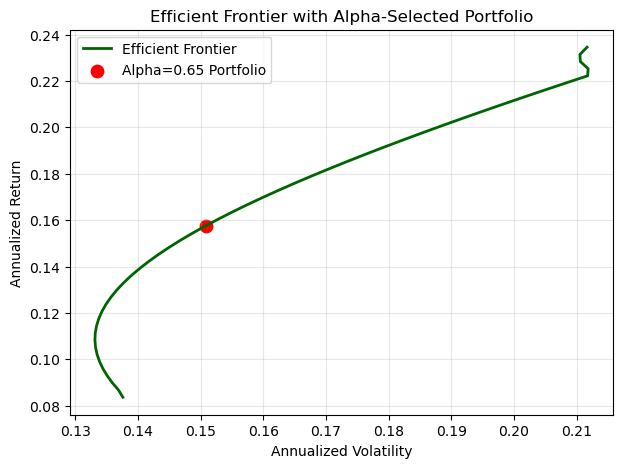

In [12]:
# -----------------------------
# 2. PORTFOLIO OPTIMISATION
# -----------------------------
print('\n=== Portfolio Optimisation ===')
portfolio = Portfolio(
    tickers_list = TICKERS,
    end_date = END_DATE,
    duration = LOOKBACK_DAYS,
    chosen_interval = INTERVAL,
    capital = CAPITAL,
    allow_short = ALLOW_SHORT
)

# Compute optimal weights with chosen alpha and generate the portfolio value series
portfolio.efficient_frontier_with_alpha(alpha=0.65)
portfolio_df = portfolio.optimized_pf()

---
### Risk Analysis

In this step, we use the `RiskAnalysis` class to **quantify and visualize downside risk** for the optimised portfolio.  
We compute **Value at Risk (VaR)** and **Conditional Value at Risk (CVaR)** using three different methodologies.


=== Risk Analysis ===


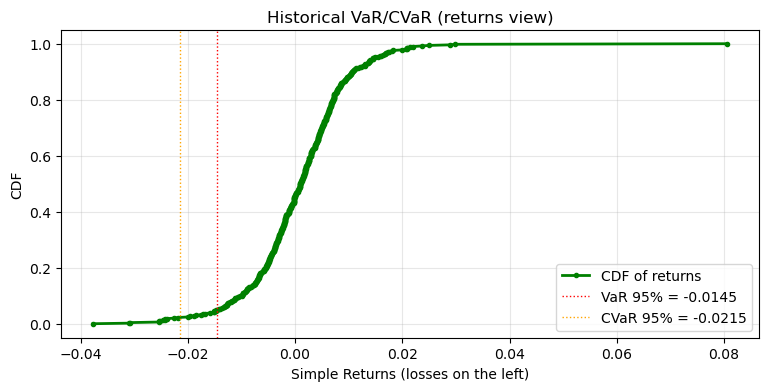

[Shapiro-Wilk] p-value = 0.0000 → Normality check of returns: negative


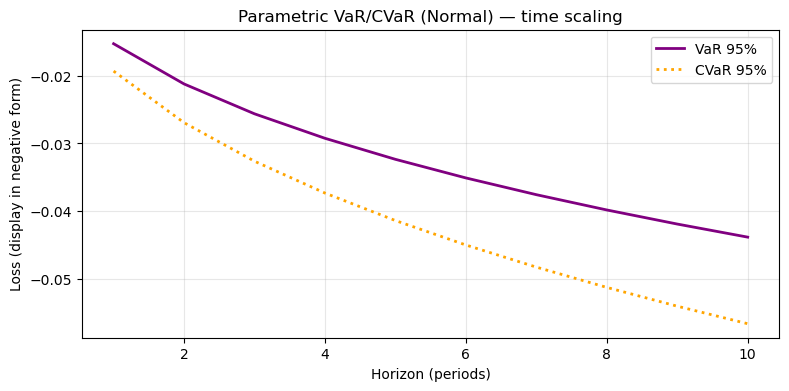

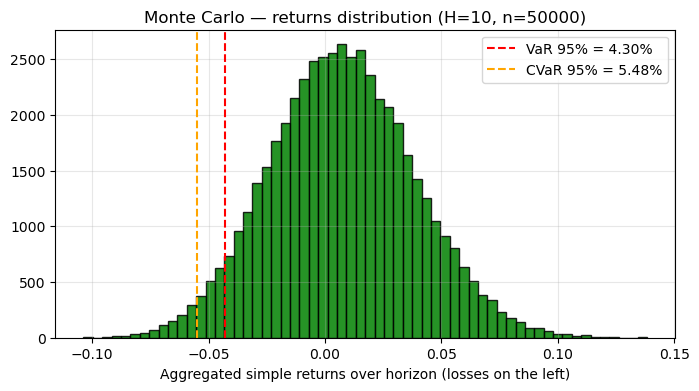

(0.04297729146837814,
 0.054806957653916105,
 -0.04297729146837814,
 -0.054806957653916105)

In [13]:
# -----------------------------
# 3. RISK ANALYSIS
# -----------------------------
print('\n=== Risk Analysis ===')
risk = RiskAnalysis(portfolio_df)

# Historical VaR/CVaR
risk.var_hist(confidence_level=confidence_level)

# Parametric VaR/CVaR
risk.var_param(confidence_level=confidence_level, days=HORIZON_DAYS)

# Monte Carlo VaR/CVaR
risk.var_montecarlo(confidence_level=confidence_level, horizon=HORIZON_DAYS, n_sims=N_SIMS)

---
### Forward Simulation

In this step, we use the `PriceSimulator` class to perform **forward-looking Monte Carlo simulations** on the **total portfolio value**.  
This approach allows us to explore a wide range of potential future outcomes and assess the portfolio’s risk profile under different market scenarios.

#### Key Capabilities
- **PnL distribution simulation** → estimates the range and likelihood of possible profit and loss outcomes over a chosen horizon.
- **Drawdown simulation** → evaluates potential peak-to-trough losses in simulated scenarios.
- **Path visualization** → displays multiple simulated portfolio value trajectories on a single chart for intuitive comparison.

#### Visualizing Simulation Paths
To see all simulated outcomes together, use:
```python
simulator.plot_paths(n_days, n_sims)



=== Forward Simulation ===


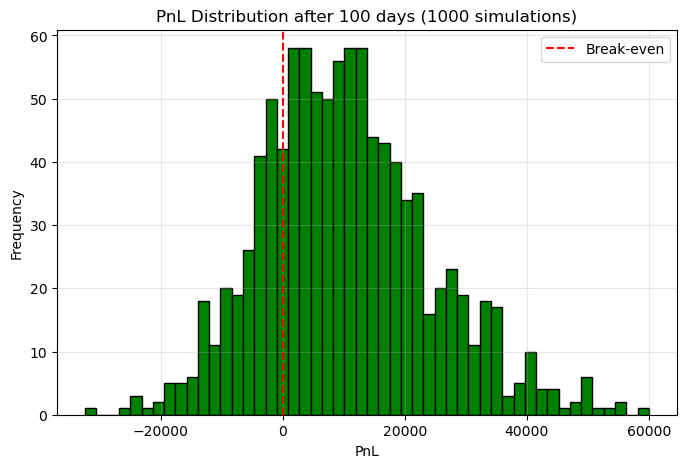

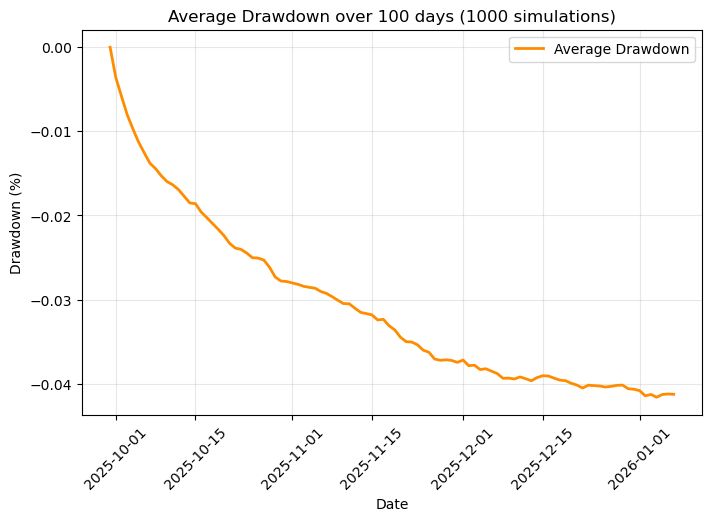

(                 0         1         2         3         4         5    \
 2025-09-30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 2025-10-01 -0.013524 -0.005586  0.000000  0.000000  0.000000  0.000000   
 2025-10-02 -0.002464  0.000000 -0.019849  0.000000 -0.023511 -0.015775   
 2025-10-03 -0.004088  0.000000 -0.015904  0.000000 -0.018657 -0.030771   
 2025-10-04 -0.008147 -0.003419 -0.027099 -0.001840 -0.013079 -0.025667   
 ...              ...       ...       ...       ...       ...       ...   
 2026-01-03 -0.049701 -0.003439 -0.068797  0.000000 -0.000921 -0.091101   
 2026-01-04 -0.051040  0.000000 -0.054837  0.000000 -0.003904 -0.109625   
 2026-01-05 -0.050220  0.000000 -0.053713  0.000000 -0.003328 -0.108484   
 2026-01-06 -0.043191  0.000000 -0.077307 -0.000732 -0.005051 -0.112572   
 2026-01-07 -0.050735 -0.006900 -0.087867 -0.013444 -0.000154 -0.108655   
 
                  6         7         8         9    ...       990       991  \
 2025-09-30  0.000

In [14]:
# -----------------------------
# 4. FORWARD SIMULATION
# -----------------------------
print('\n=== Forward Simulation ===')
simulator = PriceSimulator(portfolio_df['Total_Portfolio_Value'])

# Monte Carlo PnL distribution // add export_excel="pnl_results.xlsx" if wanted
simulator.simulate_pnl_distribution(
    n_days=MC_FORWARD_DAYS,
    n_sims=MC_FORWARD_SIMS,
)

# Monte Carlo drawdown analysis // add export_excel="drawdown_results.xlsx" if wanted
simulator.simulate_drawdowns(
    n_days=MC_FORWARD_DAYS,
    n_sims=MC_FORWARD_SIMS,
)